In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tqdm.auto import tqdm
import itertools
import scipy

import smfret.fit as fit
import smfret.dataset as dataset
import smfret.finetuning as finetuning
import smfret.evaluation as evaluation

from smfret.tf_layers import Attention
from smfret.tf_layers import Conv
from smfret.tf_layers import Summary
from smfret.tf_layers import PrependTaskToken
from smfret.tf_layers import Embedding
from smfret.tf_layers import PositionEmbedding

from smfret.trace_simulator import Simulator
from smfret.trace_simulator import ParameterGenerator
from smfret.trace_simulator import SimulatedTraceSet

from smfret.multi_task_learning import FRETStateTraceSet
from smfret.multi_task_learning import TwoStateQuickDynamicTraceSet
from smfret.multi_task_learning import EvolvingTraceSet
from smfret.multi_task_learning import SavedTraceSet
from smfret.dataset import MatlabTraceSet
from smfret.dataset import FRETTraceSet

from sklearn.manifold import TSNE
from sklearn import metrics

from scipy.stats import expon
from sciplotlib import style as spstyle

In [2]:
dataset.DONOR_TO_ACCEPTOR_CORRECTION = 0.0   # assumes that data have been corrected already.

In [3]:
rng = np.random.default_rng()

In [4]:
def load_kinsoft_synthetic_trace(path, trace_id, training=True):
    """Loads txt trace files and labels."""
    trace_txt = os.path.join(path, f'trace_{trace_id}.txt')
    label_txt = os.path.join(path, f'state_time_{trace_id}.txt')
    data = np.loadtxt(trace_txt, comments='%')
    
    structured_data = {
        'time': data[:, 0],
        'donor': data[:, 1],
        'acceptor': data[:, 2],
    }
    
    if training:
        label = np.loadtxt(label_txt, comments='%')
        time = data[:, 0]
        state_label = np.zeros_like(time)
        for state, degenerate_state, start, dwell in label:
            state_label[time >= start] = state
        structured_data['label'] = state_label - 1
    else:
        structured_data['label'] = np.zeros_like(data[:, 0])
    
    return structured_data

In [5]:
trace = load_kinsoft_synthetic_trace('challenge_data/sim_190628_100337_level1/', 1);

In [8]:
def kinsoft_trace_to_tensor(trace):
    """Properly converts a kinsoft trace into a tensor."""
    min_unit_length = 100
    trace_set = FRETTraceSet()
    for attr in trace:
        setattr(trace_set, attr, np.expand_dims(trace[attr], axis=0))
    trace_set.time = np.arange(1, trace_set.donor.shape[1] + 1)
    trace_set.size = 1
    trace_set.is_labeled = True
    trace_set.trim(len(trace_set.time) // min_unit_length * min_unit_length)
    return trace_set

In [9]:
trace_sets = []
for i in range(1, 51):
    trace = load_kinsoft_synthetic_trace('challenge_data/sim_190628_100337_level1/', i);
    trace_set = kinsoft_trace_to_tensor(trace)
    trace_sets.append(trace_set)

In [10]:
trace_set.broadcast_data_to_traces()

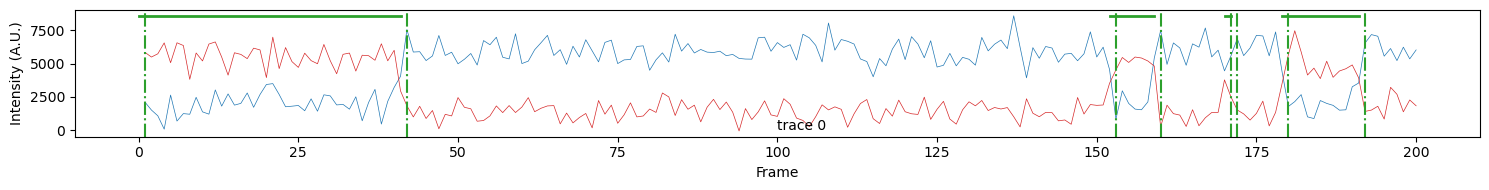

In [11]:
plt.figure(figsize=(15, 2))
trace_set.plot_traces(n_traces=1)

In [12]:
# use simulation data to fintune the model
ours = keras.models.load_model('saved_models/best_model/encoder-20240111-045226.h5', compile=False)
ours_framewise = keras.models.clone_model(ours)
ours_framewise.layers[-1].framewise = True

segmenter = finetuning.finetune_classification_head(encoder=ours_framewise, train_sets=trace_sets, epochs=50, lr=1e-2, trace_level=False, use_sklearn=True)

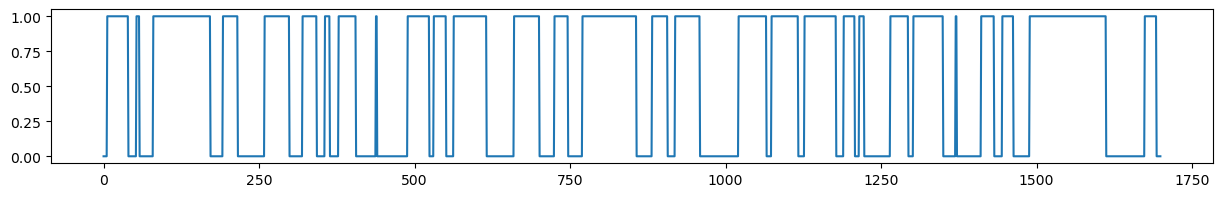

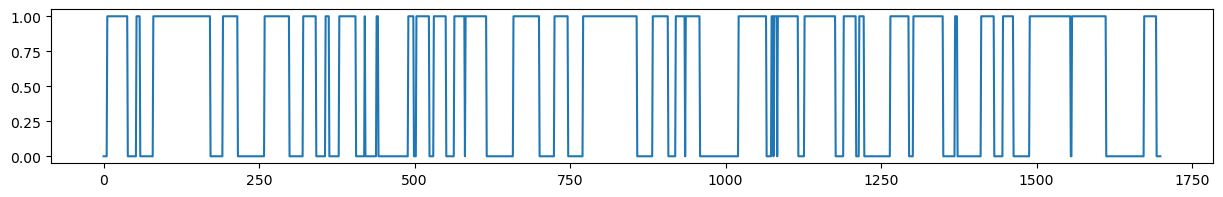

In [13]:
# visualize training results
idx = 4
plt.figure(figsize=(15, 2))
plt.plot(np.argmax(finetuning.encode_traces(encoder=segmenter, trace_set=trace_sets[idx]), axis=-1)[0, :])
plt.figure(figsize=(15, 2))
plt.plot(trace_sets[idx].label[0, :])

In [14]:
def get_fret_value(trace, states, target_state):
    """Calcualtes the mean FRET value."""
    return list(trace.fret[states == target_state])

In [15]:
def reject_outliers(data, m = 2.):
    """Reject outliner datapoints."""
    data = np.array(data)
    d = np.abs(data - np.mean(data))
    mean = np.median(d)
    s = d / mean if mean else np.zeros(len(d))
    return data[s<m]

In [43]:
# load benchmark dataset and compare against existing algorithms.

# model
# ours = keras.models.load_model('saved_models/best_model/encoder-20231213-222655.h5', compile=False)
# ours_framewise = keras.models.clone_model(ours)
# ours_framewise.layers[-1].framewise = True
# synthetic data
trace_sets = []
for i in range(1, 51):
    trace = load_kinsoft_synthetic_trace('challenge_data/sim_190628_100337_level1/', i);
    trace_set = kinsoft_trace_to_tensor(trace)
    trace_sets.append(trace_set)

test_sets = []
for i in range(1, 76):
    trace = load_kinsoft_synthetic_trace('challenge_data/sim_level1_final_publish/', i, training=False);
    test_set = kinsoft_trace_to_tensor(trace)
    test_sets.append(test_set)

repeats = 1
k_zero_one_list = []
k_one_zero_list = []
FRET_zero_list = []
FRET_one_list = []
for repeat in range(repeats):
    tau_one = []
    tau_zero = []
    FRET_zero = []
    FRET_one = []
    keras.utils.set_random_seed(150 + repeat)
    # segmenter = finetuning.finetune_classification_head(encoder=ours_framewise, train_sets=trace_sets, epochs=1000, lr=1e-2, trace_level=False, use_sklearn=True,)
    for test_set in test_sets:
        # pred_state = np.argmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_set), axis=-1)[0, ...]
        pred_state = np.convolve(tf.math.softmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_set), axis=-1).numpy()[0,...,1], np.ones(5) / 5, 'same') > 0.5
        tau_zero += evaluation.get_dwell_time(states=pred_state, target_state=0)
        tau_one += evaluation.get_dwell_time(states=pred_state, target_state=1)
        FRET_zero += get_fret_value(test_set.traces[0], pred_state, target_state=0)
        FRET_one += get_fret_value(test_set.traces[0], pred_state, target_state=1)
    
    bins = np.linspace(0, int(1.2 * np.max(tau_one + tau_zero)), 100)
    time_resolution = trace['time'][1] - trace['time'][0]
    k_one_zero, k_one_zero_std = evaluation.estimate_k(tau_one, bins=bins, time_resolution=time_resolution, tau_min=5, return_fit_err=True)
    k_zero_one, k_zero_one_std = evaluation.estimate_k(tau_zero, bins=bins, time_resolution=time_resolution, tau_min=5, return_fit_err=True)
    k_zero_one_list.append(k_zero_one)
    k_one_zero_list.append(k_one_zero)
    FRET_zero_list.append(np.mean(reject_outliers(FRET_zero, m=6)))
    FRET_one_list.append(np.mean(reject_outliers(FRET_one, m=6)))
    print('k_{12} =', k_zero_one, 'k_{21} =', k_one_zero, 'FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1])

k_{12} = 0.14238505793407988 k_{21} = 0.2150204267550269 FRET_1 = 0.24214774464739125 FRET_2 = 0.7215156616268229


(array([6.000e+00, 2.400e+01, 3.900e+01, 8.400e+01, 1.200e+02, 1.510e+02,
        1.200e+02, 9.900e+01, 9.500e+01, 9.300e+01, 1.410e+02, 3.130e+02,
        8.040e+02, 2.001e+03, 3.498e+03, 4.627e+03, 4.260e+03, 3.044e+03,
        1.714e+03, 8.210e+02, 3.410e+02, 1.150e+02, 5.700e+01, 1.500e+01,
        7.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([0.04959684, 0.09191825, 0.13423966, 0.17656108, 0.21888249,
        0.26120391, 0.30352532, 0.34584673, 0.38816815, 0.43048956,
        0.47281097, 0.51513239, 0.5574538 , 0.59977522, 0.64209663,
        0.68441804, 0.72673946, 0.76906087, 0.81138229, 0.8537037 ,
        0.89602511, 0.93834653, 0.98066794, 1.02298936, 1.06531077,
        1.10763218, 1.1499536 , 1.19227501, 1.23459642, 1.27691784,
        1.31923925]),
 <BarContainer object of 30 artists>)

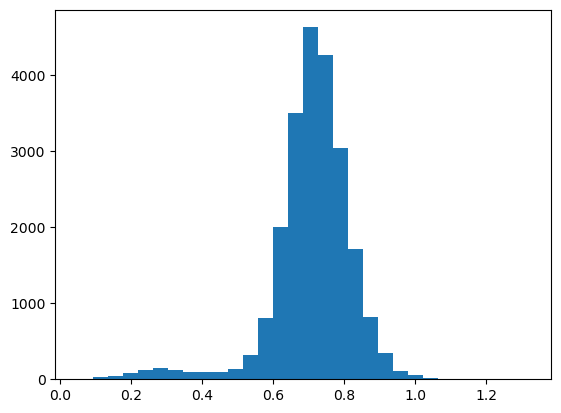

In [44]:
plt.hist(FRET_one, bins=30)

In [45]:
print(
    'k_{12} =', np.mean(reject_outliers(k_zero_one_list)), '±', k_zero_one_std,
    'k_{21} =', np.mean(reject_outliers(k_one_zero_list)), '±', k_one_zero_std,
)

k_{12} = 0.14238505793407988 ± 0.0005534352009381713 k_{21} = 0.2150204267550269 ± 0.0012422518106693142


In [46]:
print('FRET_1 =', np.mean(FRET_zero_list), '±', np.std(FRET_zero_list),'FRET_2 =', np.mean(FRET_one_list), '±', np.std(FRET_one_list))

FRET_1 = 0.24214774464739125 ± 0.0 FRET_2 = 0.7215156616268229 ± 0.0


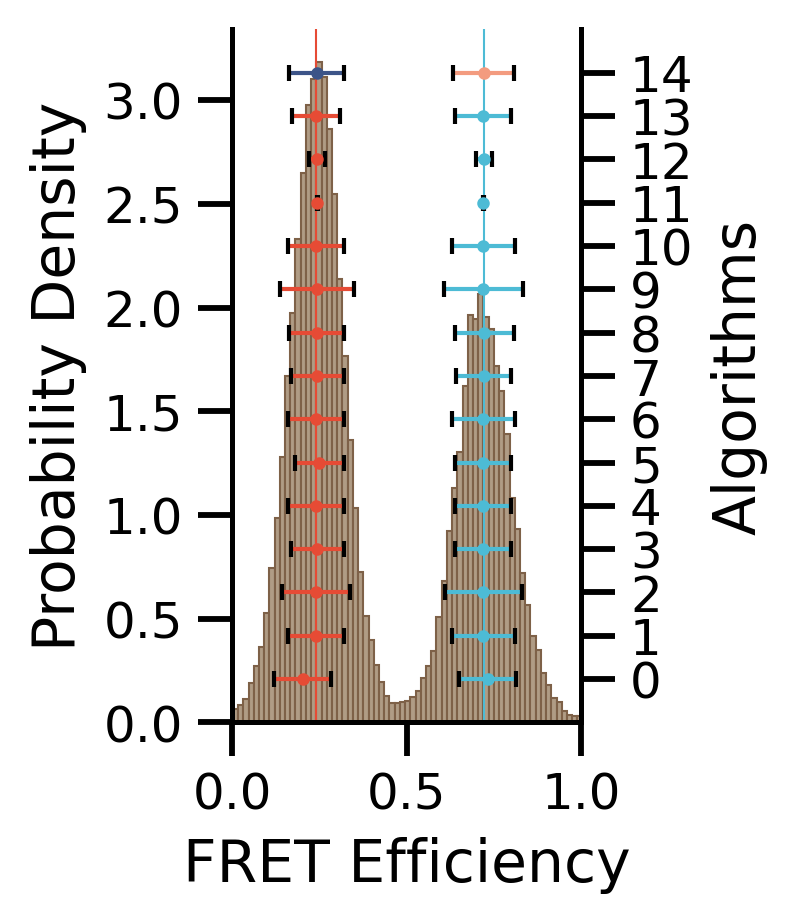

In [50]:
# generate plot

FRET = []
for test_set in test_sets:
    FRET.append(test_set.fret)

FRET = np.concatenate(FRET, axis=-1)
FRET_pdf, FRET_bins = np.histogram(FRET, bins=100, density=True)
FRET_center = (FRET_bins[:-1] + FRET_bins[1:]) / 2.0
FRET_bin_width = FRET_bins[1] - FRET_bins[0]

benchmarks = pd.read_csv('challenge_data/Source Data/Figure2/figure2_sim_summary.csv').to_dict(orient='index')
with plt.style.context(spstyle.get_style('nature-reviews')):
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig = plt.figure(figsize=(1.5, 3))

    plt.bar(FRET_center, FRET_pdf, width=FRET_bin_width, color=color[-1], edgecolor=color[-2], linewidth=0.5)
    #TODO: the simulation data has ground truth. So we shouldn't use the mean 
    plt.axvline(x=np.mean([benchmarks[idx]['FRET E 1'] for idx in range(len(benchmarks))]), color=color[0], linewidth=0.5)
    plt.axvline(x=np.mean([benchmarks[idx]['FRET E 2'] for idx in range(len(benchmarks))]), color=color[1], linewidth=0.5)
    plt.ylabel('Probability Density')
    plt.xlabel('FRET Efficiency')
    
    ax_right = plt.gca().twinx()
    ax_right.spines['right'].set_visible(True)

    for idx in range(len(benchmarks)):
        ax_right.errorbar(y=idx, x=benchmarks[idx]['FRET E 1'], xerr=benchmarks[idx]['std E1'], capsize=2, color=color[0], marker='o', markeredgecolor=color[0], markersize=2, linewidth=1)
        ax_right.errorbar(y=idx, x=benchmarks[idx]['FRET E 2'], xerr=benchmarks[idx]['std E2'], capsize=2, color=color[1], marker='o', markeredgecolor=color[1], markersize=2, linewidth=1)
    # the highest ones are "OURS"
    ax_right.errorbar(y=len(benchmarks), x=np.mean(FRET_zero_list), xerr=np.std(reject_outliers(FRET_zero, m=6)), capsize=2, color=color[3], marker='o', markeredgecolor=color[3], markersize=2, linewidth=1)
    ax_right.errorbar(y=len(benchmarks), x=np.mean(FRET_one_list), xerr=np.std(reject_outliers(FRET_one, m=6)), capsize=2, color=color[4], marker='o', markeredgecolor=color[4], markersize=2, linewidth=1)
    ax_right.set_ylabel("Algorithms")
    
    ax_right.set_yticks(np.arange(len(benchmarks) + 1))
    plt.xlim([0, 1])
    plt.ylim([-1, 15])


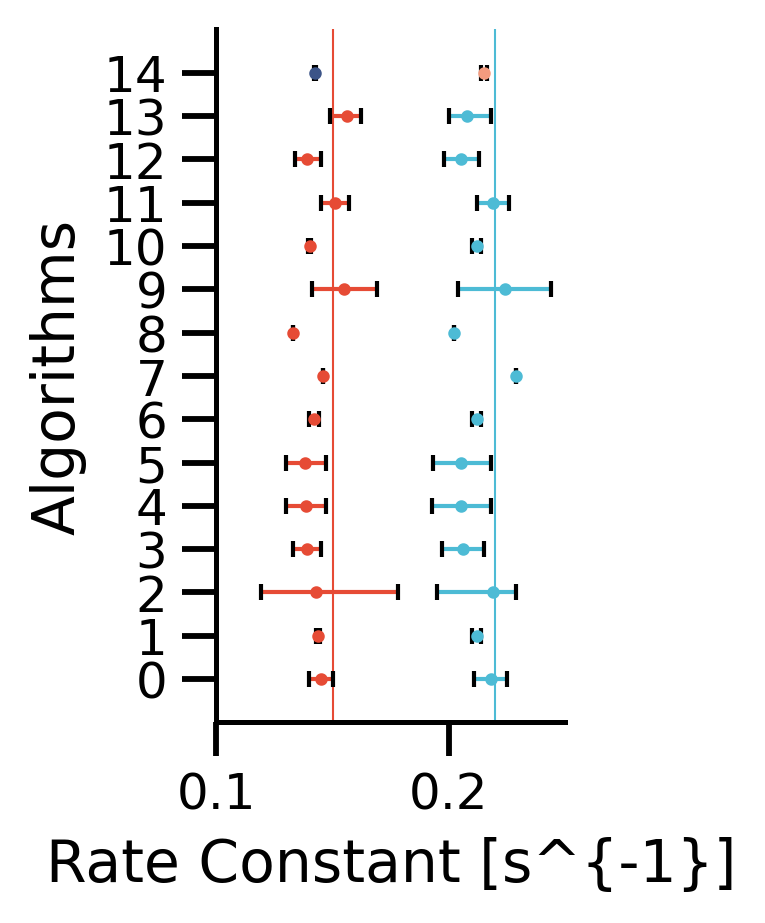

In [21]:

# Kinetics
with plt.style.context(spstyle.get_style('nature-reviews')):
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    fig = plt.figure(figsize=(1.5, 3))
    ax = plt.gca()
    #TODO: the simulation data has ground truth. So we shouldn't use the mean 
    plt.axvline(x=0.15, color=color[0], linewidth=0.5)
    plt.axvline(x=0.22, color=color[1], linewidth=0.5)
    for idx in range(len(benchmarks)):
        ax.errorbar(y=idx, x=benchmarks[idx]['k12'], xerr=np.array([[benchmarks[idx]['k12 - delta']], [benchmarks[idx]['k12 + delta']]]), capsize=2, color=color[0], marker='o', markeredgecolor=color[0], markersize=2, linewidth=1)
        ax.errorbar(y=idx, x=benchmarks[idx]['k21'], xerr=np.array([[benchmarks[idx]['k21 - delta']], [benchmarks[idx]['k21 + delta']]]), capsize=2, color=color[1], marker='o', markeredgecolor=color[1], markersize=2, linewidth=1)
    
    # the highest ones are "OURS"
    ax.errorbar(y=len(benchmarks), x=np.mean(reject_outliers(k_zero_one_list)), xerr=k_zero_one_std, capsize=2, color=color[3], marker='o', markeredgecolor=color[3], markersize=2, linewidth=1)
    ax.errorbar(y=len(benchmarks), x=np.mean(reject_outliers(k_one_zero_list)), xerr=k_one_zero_std, capsize=2, color=color[4], marker='o', markeredgecolor=color[4], markersize=2, linewidth=1)
    ax.set_ylabel("Algorithms")
   
    ax.set_yticks(np.arange(len(benchmarks) + 1))
    ax.set_xlabel("Rate Constant [s^{-1}]")
    plt.xlim([0.1, 0.25])
    plt.ylim([-1, 15])

In [16]:
def interpolate_position_embedding(position_embedding, periodicity=40):
    """Interpolates the position embedding vectors."""
    vectors = []
    w = position_embedding.variables[0]
    for i in range(w.shape[0]):
        if i == 0:
            vectors.append(w[i, :])
        elif i < periodicity:
            vectors.append(w[i, :])
        else:
            vectors.append(w[i - periodicity + 1, :])
    position_embedding.variables[0].assign(tf.stack(vectors, axis=0))

In [27]:
np.convolve(tf.math.softmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_set), axis=-1).numpy()[0,...,1], np.ones(5) / 5, 'same')

array([5.98561201e-12, 6.03570527e-12, 6.04001293e-12, ...,
       2.35661864e-06, 1.79037452e-06, 9.55909491e-07])

In [46]:
keras.mixed_precision.set_global_policy('mixed_bfloat16')
segmenter = keras.models.load_model('saved_models/model-20240511-131505/FRETSTATE.h5', compile=False, custom_objects={'PositionEmbedding': PositionEmbedding})
mid_fret_idx = segmenter.layers[-1].output_shape[-1] // 2
# experimental data

truncate_length_window = 1600
min_length_unit = 100

test_sets = []
for i in range(1, 500):
    try:
        trace = load_kinsoft_synthetic_trace('challenge_data/Traces_EG_10ms/', i, training=False)
    except:
        continue

    truncate_number = len(trace['time']) // truncate_length_window
    for j in range(truncate_number):
        trace = load_kinsoft_synthetic_trace('challenge_data/Traces_EG_10ms/', i, training=False)
        test_set = kinsoft_trace_to_tensor(trace)
        test_set.trim(truncate_length_window, start_frame=(j * truncate_length_window))
        test_set.trim(len(test_set.time) // min_length_unit * min_length_unit)
        test_sets.append(test_set)

print(len(test_sets), 'truncated traces generated from experimental data.')

repeats = 1
k_zero_one_list = []
k_one_zero_list = []
FRET_zero_list = []
FRET_one_list = []
for repeat in range(repeats):
    tau_one = []
    tau_zero = []
    FRET_zero = []
    FRET_one = []
    keras.utils.set_random_seed(140 + repeat)
    for test_set in test_sets:
        # pred_state = np.argmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_set), axis=-1)[0, ...]
        pred_state = np.convolve(tf.math.softmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_set), axis=-1).numpy()[0,...,mid_fret_idx:].sum(axis=-1), np.ones(5) / 5, 'same') > 0.5
        tau_zero += evaluation.get_dwell_time(states=pred_state, target_state=0)
        tau_one += evaluation.get_dwell_time(states=pred_state, target_state=1)
        FRET_zero += get_fret_value(test_set.traces[0], pred_state, target_state=0)
        FRET_one += get_fret_value(test_set.traces[0], pred_state, target_state=1)
    
    bins = np.linspace(0, int(1.2 * np.max(tau_one + tau_zero)), 500)
    # bins = np.linspace(0, 250, 50)
    time_resolution = 0.01
    k_one_zero, k_one_zero_std = evaluation.estimate_k(tau_one, bins=bins, time_resolution=time_resolution, tau_min=5, return_fit_err=True)
    k_zero_one, k_zero_one_std = evaluation.estimate_k(tau_zero, bins=bins, time_resolution=time_resolution, tau_min=5, return_fit_err=True)
    k_zero_one_list.append(k_zero_one)
    k_one_zero_list.append(k_one_zero)
    FRET_zero_list.append(np.mean(reject_outliers(FRET_zero, m=5)))
    FRET_one_list.append(np.mean(reject_outliers(FRET_one, m=5)))
    print('k_{12} =', k_zero_one, 'k_{21} =', k_one_zero, 'FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1])

131 truncated traces generated from experimental data.
k_{12} = 2.6725470600298165 k_{21} = 3.3075204656750867 FRET_1 = 0.26737260096243853 FRET_2 = 0.7124205516003589


In [50]:
# experimental data with fine-tuning

truncate_length_window = 1600
min_length_unit = 100

# model
ours = keras.models.load_model('saved_models/best_model/encoder-20240111-045226.h5', compile=False)
ours_framewise = keras.models.clone_model(ours)
ours_framewise.layers[-1].framewise = True

# experimental data
trace_sets = []
for i in range(1, 51):
    # we still use the synthetic data for finetuning
    trace = load_kinsoft_synthetic_trace('challenge_data/sim_190628_100337_level1/', i);
    trace_set = kinsoft_trace_to_tensor(trace)
    trace_sets.append(trace_set)

test_sets = []
for i in range(1, 500):
    try:
        trace = load_kinsoft_synthetic_trace('challenge_data/Traces_EG_10ms/', i, training=False)
    except:
        continue

    truncate_number = len(trace['time']) // truncate_length_window
    for j in range(truncate_number):
        trace = load_kinsoft_synthetic_trace('challenge_data/Traces_EG_10ms/', i, training=False)
        test_set = kinsoft_trace_to_tensor(trace)
        test_set.trim(truncate_length_window, start_frame=(j * truncate_length_window))
        test_set.trim(len(test_set.time) // min_length_unit * min_length_unit)
        test_sets.append(test_set)

print(len(test_sets), 'truncated traces generated from experimental data.')

repeats = 1
k_zero_one_list = []
k_one_zero_list = []
FRET_zero_list = []
FRET_one_list = []
for repeat in range(repeats):
    tau_one = []
    tau_zero = []
    FRET_zero = []
    FRET_one = []
    keras.utils.set_random_seed(140 + repeat)
    segmenter = finetuning.finetune_classification_head(encoder=ours_framewise, train_sets=trace_sets, epochs=500, lr=1e-2, trace_level=False, use_sklearn=True)
    for test_set in test_sets:
        # pred_state = np.argmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_set), axis=-1)[0, ...]
        pred_state = np.convolve(tf.math.softmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_set), axis=-1).numpy()[0,...,1], np.ones(5) / 5, 'same') > 0.5
        tau_zero += evaluation.get_dwell_time(states=pred_state, target_state=0)
        tau_one += evaluation.get_dwell_time(states=pred_state, target_state=1)
        FRET_zero += get_fret_value(test_set.traces[0], pred_state, target_state=0)
        FRET_one += get_fret_value(test_set.traces[0], pred_state, target_state=1)
    
    bins = np.linspace(0, int(1.2 * np.max(tau_one + tau_zero)), 500)
    # bins = np.linspace(0, 250, 50)
    time_resolution = 0.01
    k_one_zero, k_one_zero_std = evaluation.estimate_k(tau_one, bins=bins, time_resolution=time_resolution, tau_min=5, return_fit_err=True)
    k_zero_one, k_zero_one_std = evaluation.estimate_k(tau_zero, bins=bins, time_resolution=time_resolution, tau_min=5, return_fit_err=True)
    k_zero_one_list.append(k_zero_one)
    k_one_zero_list.append(k_one_zero)
    FRET_zero_list.append(np.mean(reject_outliers(FRET_zero, m=5)))
    FRET_one_list.append(np.mean(reject_outliers(FRET_one, m=5)))
    print('k_{12} =', k_zero_one, 'k_{21} =', k_one_zero, 'FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1])

131 truncated traces generated from experimental data.
k_{12} = 2.714706587276355 k_{21} = 3.2403493781960333 FRET_1 = 0.2683935445355566 FRET_2 = 0.7125820249155238


In [49]:
print(
    'k_{12} =', np.mean(reject_outliers(k_zero_one_list)), '±', k_zero_one_std,
    'k_{21} =', np.mean(reject_outliers(k_one_zero_list)), '±', k_one_zero_std,
)

k_{12} = 2.6725470600298165 ± 0.008719038875710666 k_{21} = 3.3075204656750867 ± 0.016866145062012356


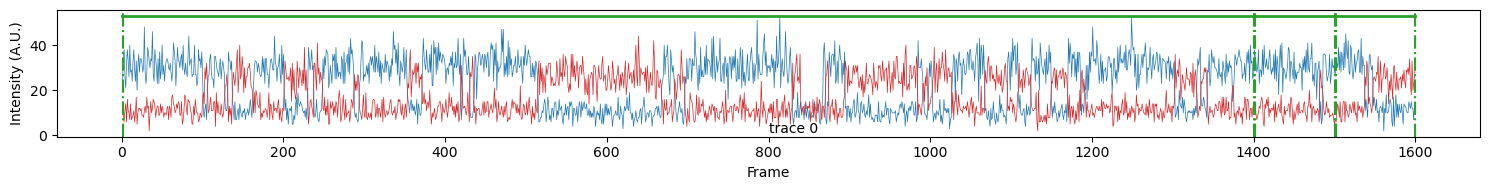

In [30]:
idx = 5
plt.figure(figsize=(15, 2))
test_sets[idx].label = np.argmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_sets[idx]), axis=-1)
test_sets[idx].plot_traces(n_traces=1)

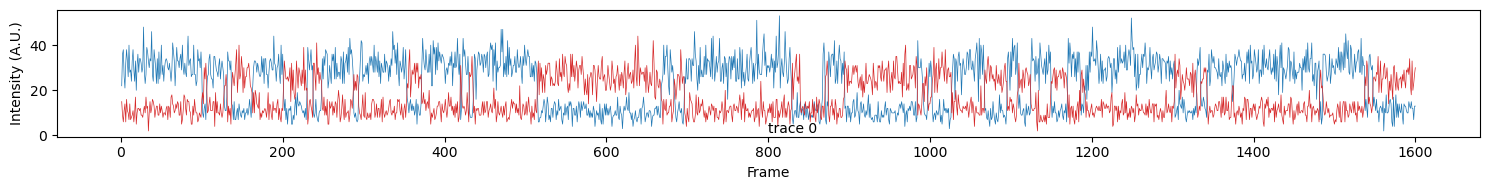

In [31]:
idx = 5
plt.figure(figsize=(15, 2))
test_sets[idx].label = np.expand_dims(np.convolve(tf.math.softmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_sets[idx]), axis=-1).numpy()[0,...,-1], np.ones(5) / 5, 'same'), 0) > 0.5
test_sets[idx].plot_traces(n_traces=1)

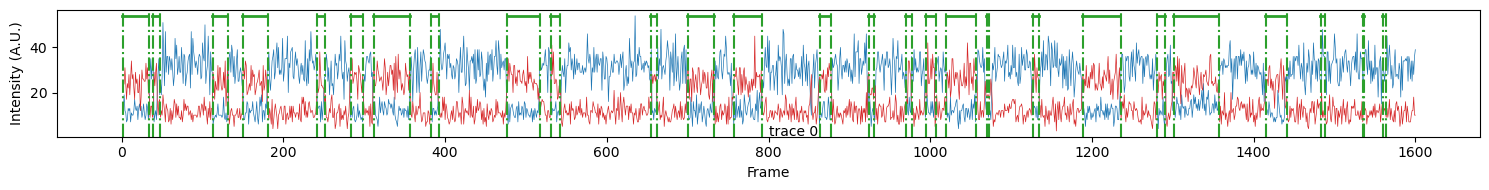

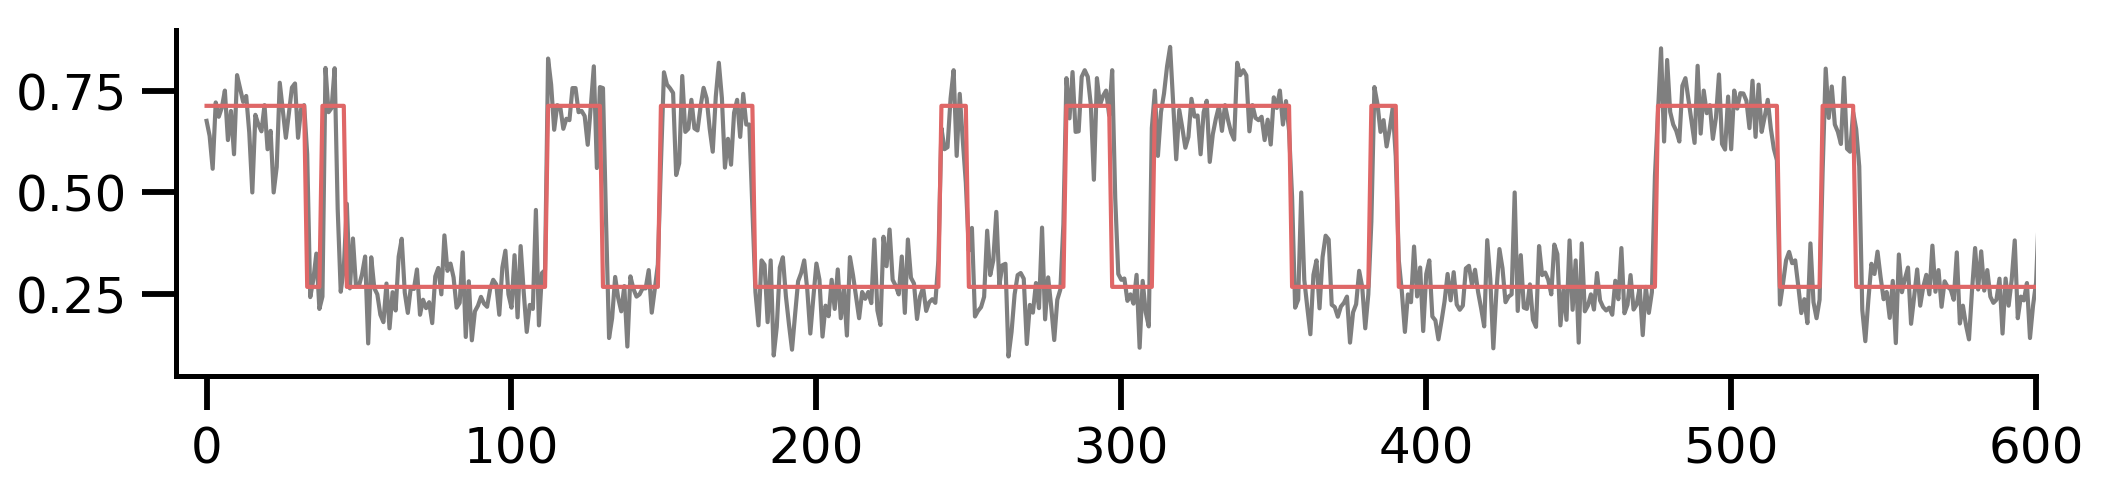

In [131]:
idx = 10
plt.figure(figsize=(15, 2))
test_sets[idx].label = np.expand_dims(np.convolve(tf.math.softmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_sets[idx]), axis=-1).numpy()[0,...,-1], np.ones(3) / 3, 'same'), 0) > 0.5
test_sets[idx].plot_traces(n_traces=1)
with plt.style.context(spstyle.get_style('nature-reviews')):
    plt.figure(figsize=(8, 1.5))
    color[0], color[1] = '#559AD1', '#DF6767'
    plt.plot(test_sets[idx].traces[0].fret, linewidth=1, color='black', alpha=0.5)
    plt.plot(test_sets[idx].label[0, :] * (FRET_one_list[0] - FRET_zero_list[0]) + FRET_zero_list[0], linewidth=1, color=color[1])
    plt.xlim([-10, 600])
    plt.savefig('figures/fig3-idealization-trace.svg', transparent=True, dpi=120)

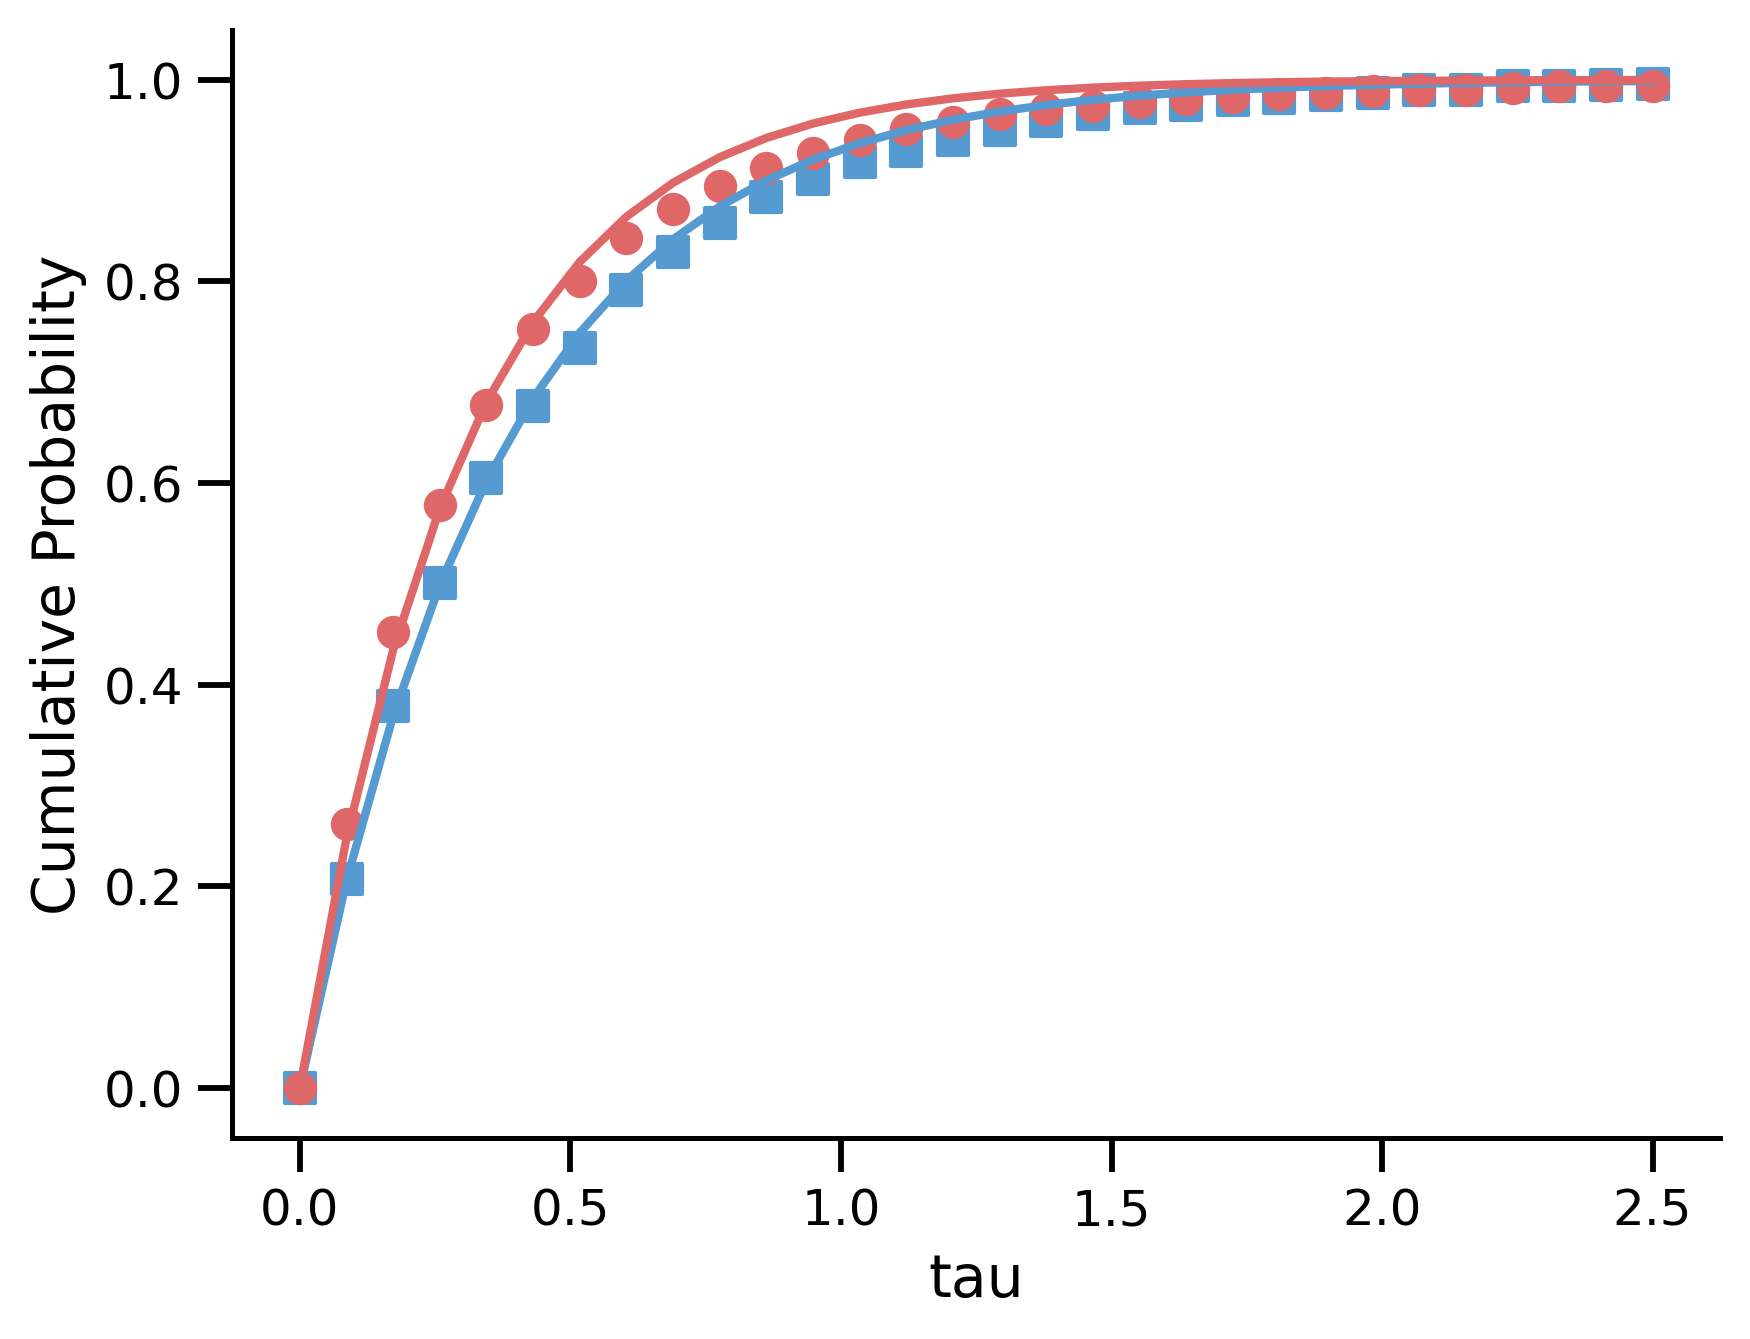

In [37]:
bins = np.linspace(0, 250, 30)
b = 5
with plt.style.context(spstyle.get_style('nature-reviews')):
    # plt.figure(figsize=(8, 6))
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color[0], color[1] = '#559AD1', '#DF6767'
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_zero if x > b], bins=bins), color=color[0], marker='s')
    plt.plot(bins * time_resolution, 1 - np.exp(- k_zero_one * time_resolution * bins), color=color[0])
    plt.scatter(bins * time_resolution, evaluation.get_cdf([x - b for x in tau_one if x > b], bins=bins), color=color[1])
    plt.plot(bins * time_resolution, 1 - np.exp(- k_one_zero * time_resolution * bins), color=color[1])
    plt.xlabel('tau')
    plt.ylabel('Cumulative Probability')
    # plt.savefig('figures/fig3-idealization-cumulative-prob-fit.svg', transparent=True, dpi=120)

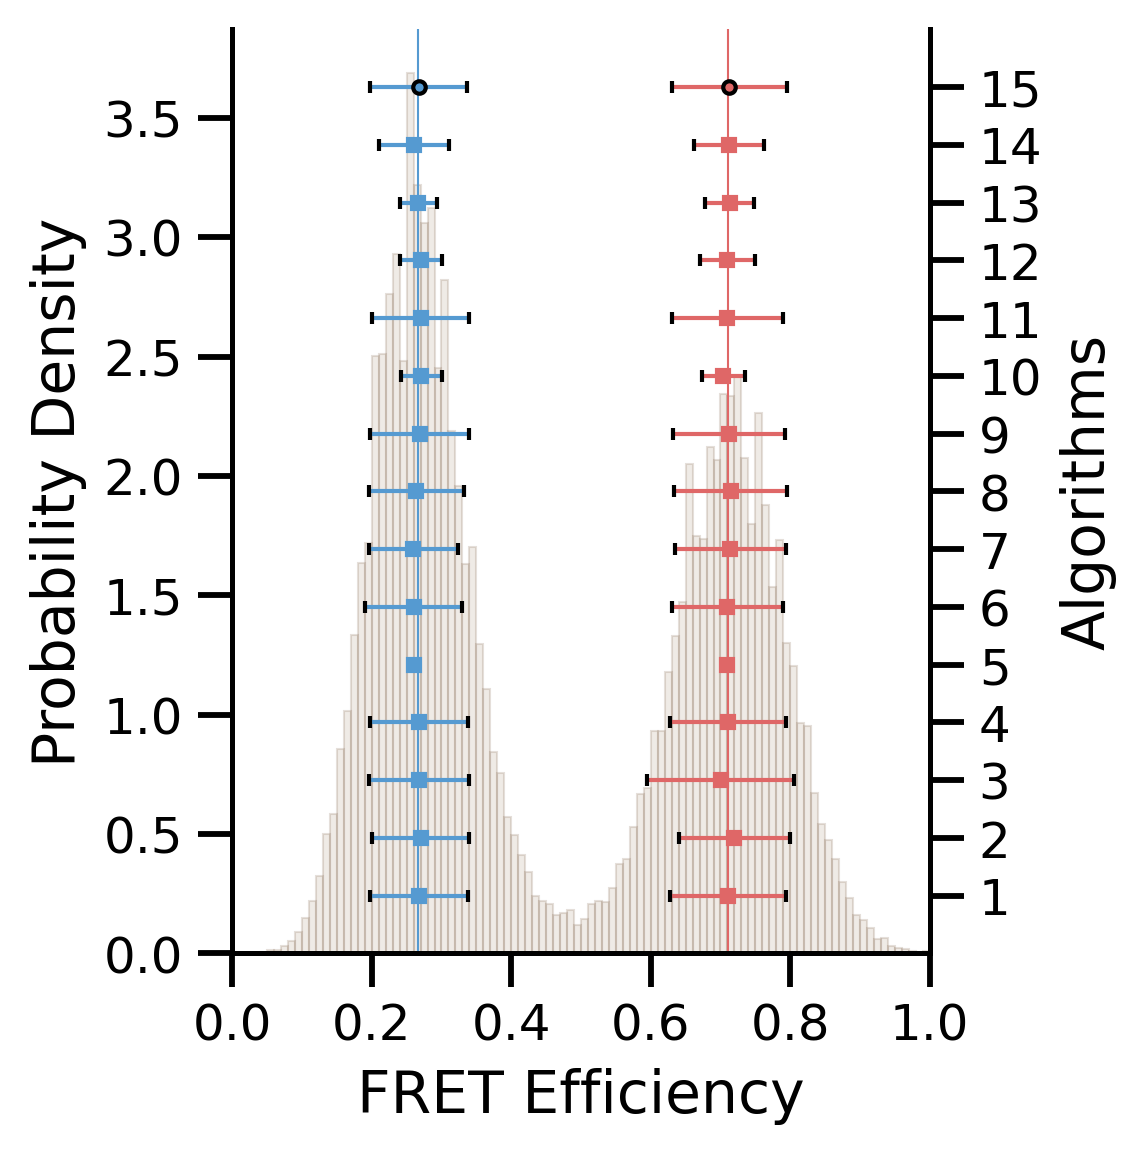

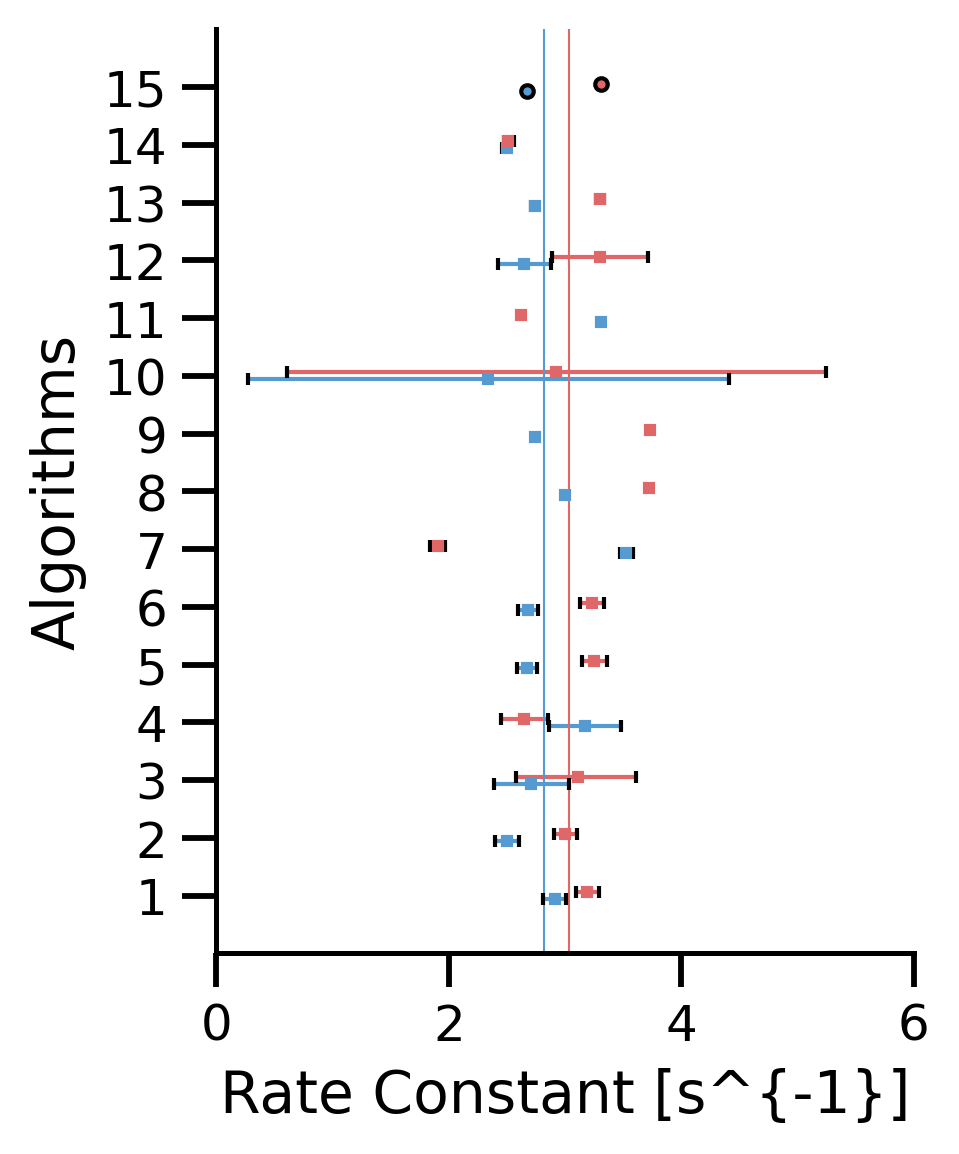

In [48]:
# generate plot

FRET = []
for test_set in test_sets:
    FRET.append(test_set.fret)

FRET = np.concatenate(FRET, axis=-1)
FRET_pdf, FRET_bins = np.histogram(FRET, bins=100, density=True)
FRET_center = (FRET_bins[:-1] + FRET_bins[1:]) / 2.0
FRET_bin_width = FRET_bins[1] - FRET_bins[0]

benchmarks = pd.read_csv('challenge_data/Source Data/Figure2/figure2_expt_summary.csv').to_dict(orient='index')
with plt.style.context(spstyle.get_style('nature-reviews')):
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color[0], color[1] = '#559AD1', '#DF6767'
    fig = plt.figure(figsize=(3, 4))

    plt.bar(FRET_center, FRET_pdf, width=FRET_bin_width, color=color[-1], edgecolor=color[-2], linewidth=0.5, alpha=0.2)
    plt.axvline(x=np.mean([benchmarks[idx]['FRET E 1'] for idx in range(len(benchmarks))]), color=color[0], linewidth=0.5)
    plt.axvline(x=np.mean([benchmarks[idx]['FRET E 2'] for idx in range(len(benchmarks))]), color=color[1], linewidth=0.5)
    plt.ylabel('Probability Density')
    plt.xlabel('FRET Efficiency')
    
    ax_right = plt.gca().twinx()
    ax_right.spines['right'].set_visible(True)

    for idx in range(len(benchmarks)):
        ax_right.errorbar(y=idx+1, x=benchmarks[idx]['FRET E 1'], xerr=benchmarks[idx]['std E1'], capsize=1.5, color=color[0], marker='s', markeredgecolor=color[0], markersize=3, linewidth=1)
        ax_right.errorbar(y=idx+1, x=benchmarks[idx]['FRET E 2'], xerr=benchmarks[idx]['std E2'], capsize=1.5, color=color[1], marker='s', markeredgecolor=color[1], markersize=3, linewidth=1)
    # the highest ones are "OURS"
    ax_right.errorbar(y=len(benchmarks)+1, x=np.mean(FRET_zero_list), xerr=np.std(reject_outliers(FRET_zero, m=5)), capsize=1.5, color=color[0], marker='o', markeredgecolor='k', markersize=3, linewidth=1)
    ax_right.errorbar(y=len(benchmarks)+1, x=np.mean(FRET_one_list), xerr=np.std(reject_outliers(FRET_one, m=5)), capsize=1.5, color=color[1], marker='o', markeredgecolor='k', markersize=3, linewidth=1)
    ax_right.set_ylabel("Algorithms")
    
    ax_right.set_yticks(np.arange(1, len(benchmarks) + 2))
    plt.xlim([0, 1])
    plt.ylim([0, 16])
    plt.savefig('figures/fig3-idealization-fret-value.svg', transparent=True, dpi=120)

# Kinetics
with plt.style.context(spstyle.get_style('nature-reviews')):
    color = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color[0], color[1] = '#559AD1', '#DF6767'
    fig = plt.figure(figsize=(3, 4))
    ax = plt.gca()
    plt.axvline(x=np.mean([benchmarks[idx]['k12'] for idx in range(len(benchmarks))]), color=color[0], linewidth=0.5)
    plt.axvline(x=np.mean([benchmarks[idx]['k21'] for idx in range(len(benchmarks))]), color=color[1], linewidth=0.5)
    for idx in range(len(benchmarks)):
        ax.errorbar(y=idx-0.06 + 1, x=benchmarks[idx]['k12'], xerr=np.array([[benchmarks[idx]['k12 - delta']], [benchmarks[idx]['k12 + delta']]]), capsize=1.5, color=color[0], marker='s', markeredgecolor=color[0], markersize=2, linewidth=1)
        ax.errorbar(y=idx+0.06 + 1, x=benchmarks[idx]['k21'], xerr=np.array([[benchmarks[idx]['k21 - delta']], [benchmarks[idx]['k21 + delta']]]), capsize=1.5, color=color[1], marker='s', markeredgecolor=color[1], markersize=2, linewidth=1)
    
    # the highest ones are "OURS"
    ax.errorbar(y=len(benchmarks)-0.06 + 1, x=np.mean(reject_outliers(k_zero_one_list)), xerr=k_zero_one_std, capsize=1.5, color=color[0], marker='o', markeredgecolor='k', markersize=3, linewidth=1)
    ax.errorbar(y=len(benchmarks)+0.06 + 1, x=np.mean(reject_outliers(k_one_zero_list)), xerr=k_one_zero_std, capsize=1.5, color=color[1], marker='o', markeredgecolor='k', markersize=3, linewidth=1)
    ax.set_ylabel("Algorithms")
   
    ax.set_yticks(np.arange(1, len(benchmarks) + 2))
    ax.set_xlabel("Rate Constant [s^{-1}]")
    plt.xlim([0.0, 6.0])
    plt.ylim([0, 16])
    plt.savefig('figures/fig3-idealization-fret-k.svg', transparent=True, dpi=120)

In [54]:
print('k_{12} =', k_zero_one, 'k_{21} =', k_one_zero, 'FRET_1 =', FRET_zero_list[-1], 'FRET_2 =', FRET_one_list[-1])

k_{12} = 2.714706587276355 k_{21} = 3.2403493781960333 FRET_1 = 0.2683935445355566 FRET_2 = 0.7125820249155238


In [65]:
b = [benchmarks[idx]['FRET E 1'] for idx in range(len(benchmarks))]
print('FRET_1 error =', np.abs(FRET_zero_list[-1] - np.mean(b)) / np.mean(b) * 100, '%')
print('FRET_1 std among benchmarks =', np.mean(np.abs(b - np.mean(b))) / np.mean(b) * 100, '%')

FRET_1 error = 0.8686646620761524 %
FRET_1 std among benchmarks = 1.3830504738058962 %


In [64]:
b = [benchmarks[idx]['FRET E 2'] for idx in range(len(benchmarks))]
print('FRET_2 error =', np.abs(FRET_one_list[-1] - np.mean(b)) / np.mean(b) * 100, '%')
print('FRET_2 std among benchmarks =', np.mean(np.abs(b - np.mean(b))) / np.mean(b) * 100, '%')

FRET_2 error = 0.23933059194364126 %
FRET_2 std among benchmarks = 0.4277193647302735 %


In [62]:
b = [benchmarks[idx]['k12'] for idx in range(len(benchmarks))]
print('k_{12} error =', np.abs(k_zero_one - np.mean(b)) / np.mean(b) * 100, '%')
print('k_{12} std among benchmarks =', np.mean(np.abs(b - np.mean(b))) / np.mean(b) * 100, '%')

k_{12} error = 3.643725119231347 %
k_{12} std among benchmarks = 9.249691861652538 %


In [63]:
b = [benchmarks[idx]['k21'] for idx in range(len(benchmarks))]
print('k_{21} error =', np.abs(k_one_zero - np.mean(b)) / np.mean(b) * 100, '%')
print('k_{21} std among benchmarks =', np.mean(np.abs(b - np.mean(b))) / np.mean(b) * 100, '%')

k_{21} error = 6.861762488933312 %
k_{21} std among benchmarks = 12.14874312659715 %


In [ ]:
# 3-state synthetic data
# I think the k calculation has problem

# model
ours = keras.models.load_model('saved_models/best_model/encoder-20231213-222655.h5', compile=False)
ours_framewise = keras.models.clone_model(ours)
ours_framewise.layers[-1].framewise = True
# synthetic data
trace_sets = []
for i in range(1, 51):
    trace = load_kinsoft_synthetic_trace('challenge_data/sim_190628_145823_level2/', i);
    trace_set = kinsoft_trace_to_tensor(trace)
    trace_sets.append(trace_set)

test_sets = []
for i in range(1, 151):
    trace = load_kinsoft_synthetic_trace('challenge_data/sim_level2_final_publish/', i, training=False);
    test_set = kinsoft_trace_to_tensor(trace)
    test_sets.append(test_set)

repeats = 2
k_zero_list = []
k_one_list = []
k_two_list = []
FRET_zero_list = []
FRET_one_list = []
FRET_two_list = []
for repeat in range(repeats):
    tau_zero = []
    tau_one = []
    tau_two = []
    FRET_zero = []
    FRET_one = []
    FRET_two = []
    keras.utils.set_random_seed(140 + repeat)
    segmenter = finetuning.finetune_classification_head(encoder=ours_framewise, train_sets=trace_sets, num_classes=3, epochs=1000, lr=1e-2, trace_level=False, balance_class_weight=False)
    for test_set in test_sets:
        pred_state = np.argmax(finetuning.encode_traces(encoder=segmenter, trace_set=test_set), axis=-1)[0, ...]
        tau_zero += evaluation.get_dwell_time(states=pred_state, target_state=0)
        tau_one += evaluation.get_dwell_time(states=pred_state, target_state=1)
        tau_two += evaluation.get_dwell_time(states=pred_state, target_state=2)
        FRET_zero.append(get_fret_value(test_set.traces[0], pred_state, target_state=0))
        FRET_one.append(get_fret_value(test_set.traces[0], pred_state, target_state=1))
        FRET_two.append(get_fret_value(test_set.traces[0], pred_state, target_state=2))
    
    bins = np.linspace(0, int(1.2 * np.max(tau_zero + tau_one_ + tau_two)), 500)
    time_resolution = trace['time'][1] - trace['time'][0]
    min_tau = 5
    k_zero = evaluation.estimate_k(tau_zero, bins=bins, time_resolution=time_resolution, tau_min=min_tau)
    k_one = evaluation.estimate_k(tau_one, bins=bins, time_resolution=time_resolution, tau_min=min_tau)
    k_two = evaluation.estimate_k(tau_two, bins=bins, time_resolution=time_resolution, tau_min=min_tau)
    print(
        'k_{12} + k_{13} =', k_zero, 
        'k_{21} + k_{23} =', k_one, 
        'k_{31} + k_{32} =', k_two,
    )
    k_zero_list.append(k_zero)
    k_one_list.append(k_one)
    k_two_list.append(k_two)
    FRET_zero_list.append(np.nanmean(FRET_zero))
    FRET_one_list.append(np.nanmean(FRET_one))
    FRET_two_list.append(np.nanmean(FRET_two))

In [64]:
print('FRET_1 =', np.mean(FRET_zero_list), '±', np.std(FRET_zero_list),
      'FRET_2 =', np.mean(FRET_one_list), '±', np.std(FRET_one_list),
      'FRET_3 =', np.mean(FRET_two_list), '±', np.std(FRET_two_list),
     )

FRET_1 = 0.12560933908681063 ± 0.0030602790659321685 FRET_2 = 0.530220302441702 ± 0.006067283677886781 FRET_3 = 0.8746988522272742 ± 0.0031595744903027967


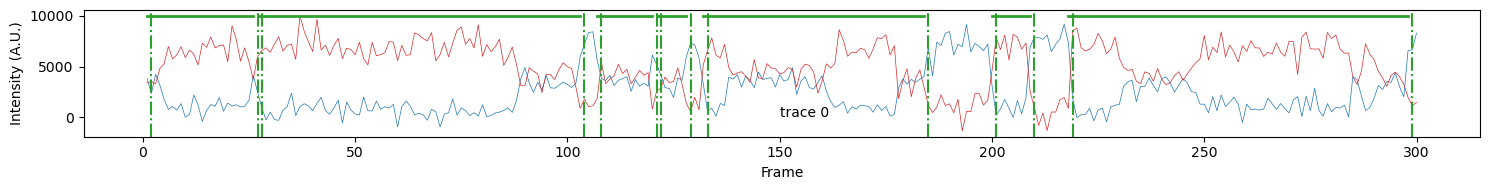

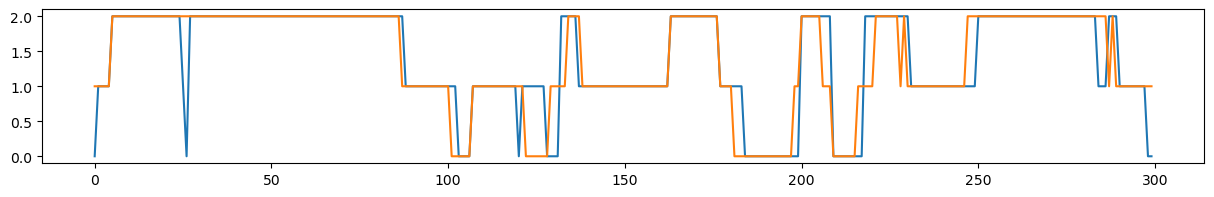

In [39]:
idx = 2
plt.figure(figsize=(15, 2))
pred_label = np.argmax(finetuning.encode_traces(encoder=segmenter, trace_set=trace_sets[idx]), axis=-1)
trace_sets[idx].plot_traces(n_traces=1)
plt.figure(figsize=(15, 2))
plt.plot(trace_sets[idx].label.transpose())
plt.plot(pred_label.transpose())